In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
parisrohan_credit_score_classification_path = kagglehub.dataset_download('parisrohan/credit-score-classification')

print('Data source import complete.')


Data source import complete.


In [2]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, make_scorer



In [3]:
# Step 1: Load Dataset
df = pd.read_csv('/kaggle/input/credit-score-classification/train.csv')


<ipython-input-3-5b4b317f1f92>:2: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/kaggle/input/credit-score-classification/train.csv')


In [4]:
df.shape

(100000, 28)

In [5]:
df

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0x25fe9,CUS_0x942c,April,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,...,_,502.38,34.663572,31 Years and 6 Months,No,35.104023,60.97133255718485,High_spent_Large_value_payments,479.866228,Poor
99996,0x25fea,CUS_0x942c,May,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,...,_,502.38,40.565631,31 Years and 7 Months,No,35.104023,54.18595028760385,High_spent_Medium_value_payments,496.65161,Poor
99997,0x25feb,CUS_0x942c,June,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,...,Good,502.38,41.255522,31 Years and 8 Months,No,35.104023,24.02847744864441,High_spent_Large_value_payments,516.809083,Poor
99998,0x25fec,CUS_0x942c,July,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,...,Good,502.38,33.638208,31 Years and 9 Months,No,35.104023,251.67258219721603,Low_spent_Large_value_payments,319.164979,Standard


In [7]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=5688cbad1cc0d54d196ae24462ad28448da4cde42015da0a94565634f846c06d
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [8]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 5.7 MB/s eta 0:00:00


In [9]:
import shap
from lime.lime_tabular import LimeTabularExplainer

from sklearn.preprocessing import LabelEncoder
import category_encoders as ce

In [10]:
df = df.drop(columns=[
    'ID', 'Customer_ID', 'Name', 'SSN'
])

le = LabelEncoder()
df['Credit_Score'] = le.fit_transform(df['Credit_Score'])

one_hot_cols = ['Month', 'Occupation', 'Payment_of_Min_Amount', 'Payment_Behaviour']
df = pd.get_dummies(df, columns=one_hot_cols, drop_first=True)

credit_mix_map = {'Bad': 0, 'Standard': 1, 'Good': 2, 'Excellent': 3}
df['Credit_Mix'] = df['Credit_Mix'].map(credit_mix_map)

target_encoder = ce.TargetEncoder()
df['Type_of_Loan'] = target_encoder.fit_transform(df['Type_of_Loan'], df['Credit_Score'])


df = df.fillna(df.mean(numeric_only=True))

def convert_credit_age(val):
    try:
        years = int(val.split(" ")[0])
        months = int(val.split(" ")[3])
        return years * 12 + months
    except:
        return None

df['Credit_History_Age'] = df['Credit_History_Age'].apply(convert_credit_age)

In [11]:
object_cols = df.select_dtypes(include='object').columns
print(object_cols)
for col in object_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')


Index(['Age', 'Annual_Income', 'Num_of_Loan', 'Num_of_Delayed_Payment',
       'Changed_Credit_Limit', 'Outstanding_Debt', 'Amount_invested_monthly',
       'Monthly_Balance'],
      dtype='object')


In [13]:

# Step 3: Feature Selection - Chi-Square
X = df.drop('Credit_Score', axis=1)
y = df['Credit_Score']

In [14]:
for col in X.columns:
    if X[col].dtype in ['float64', 'int64']:
        X[col].fillna(X[col].median(), inplace=True)
    else:
        X[col].fillna(X[col].mode()[0], inplace=True)

y.fillna(y.mode()[0], inplace=True)

<ipython-input-14-8c83a6e02682>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(X[col].median(), inplace=True)
<ipython-input-14-8c83a6e02682>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

In [17]:

# Step 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.34, random_state=42)


In [18]:

# Step 5: Train Classifiers
# Random Forest
start_time_rf = time.time()
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
training_time_rf = time.time() - start_time_rf

# Naive Bayes
start_time_nb = time.time()
nb = GaussianNB()
nb.fit(X_train, y_train)
training_time_nb = time.time() - start_time_nb

# Bayesian Classifier (Logistic Regression as proxy for Bayesian)
start_time_bayes = time.time()
bayes = LogisticRegression(max_iter=1000)
bayes.fit(X_train, y_train)
training_time_bayes = time.time() - start_time_bayes

# Support Vector Machine (RBF Kernel)
start_time_svm = time.time()
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train, y_train)
training_time_svm = time.time() - start_time_svm


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [20]:


# Step 6: Predictions and Evaluation Function
def evaluate_model(model, X_test, y_test, name, training_time):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)
    fp = cm[0][1] / (cm[0][0] + cm[0][1])
    fn = cm[1][0] / (cm[1][0] + cm[1][1])
    print(f"\n{name} Evaluation:")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"False Positive Rate (FPR): {fp:.4f}")
    print(f"False Negative Rate (FNR): {fn:.4f}")
    print(f"Training Time: {training_time:.4f} seconds")

# Evaluate all models
evaluate_model(rf, X_test, y_test, "Random Forest", training_time_rf)
evaluate_model(nb, X_test, y_test, "Naive Bayes", training_time_nb)
evaluate_model(bayes, X_test, y_test, "Bayesian Classifier (Logistic Regression)", training_time_bayes)
evaluate_model(svm, X_test, y_test, "Support Vector Machine (SVM)", training_time_svm)



Random Forest Evaluation:
Accuracy: 0.8016
F1 Score: 0.8017
False Positive Rate (FPR): 0.0194
False Negative Rate (FNR): 0.0249
Training Time: 41.9441 seconds

Naive Bayes Evaluation:
Accuracy: 0.5433
F1 Score: 0.5420
False Positive Rate (FPR): 0.1340
False Negative Rate (FNR): 0.1086
Training Time: 0.2638 seconds

Bayesian Classifier (Logistic Regression) Evaluation:
Accuracy: 0.5412
F1 Score: 0.4711
False Positive Rate (FPR): 0.5261
False Negative Rate (FNR): 0.0085
Training Time: 65.6056 seconds

Support Vector Machine (SVM) Evaluation:
Accuracy: 0.5312
F1 Score: 0.3685
False Positive Rate (FPR): nan
False Negative Rate (FNR): nan
Training Time: 3618.6343 seconds


<ipython-input-20-5ec8a98a1109>:7: RuntimeWarning: invalid value encountered in scalar divide
  fp = cm[0][1] / (cm[0][0] + cm[0][1])
<ipython-input-20-5ec8a98a1109>:8: RuntimeWarning: invalid value encountered in scalar divide
  fn = cm[1][0] / (cm[1][0] + cm[1][1])


In [ ]:

# Step 7: 10-Fold Cross Validation
def cross_validate_model(model, X, y, name):
    cv_scores = cross_val_score(model, X, y, cv=10, scoring=make_scorer(f1_score))
    print(f"{name} 10-Fold CV F1 Score: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

print("\nCross Validation Results:")
cross_validate_model(rf, X, y, "Random Forest")
cross_validate_model(nb, X, y, "Naive Bayes")
cross_validate_model(bayes, X, y, "Bayesian Classifier (Logistic Regression)")
cross_validate_model(svm, X, y, "Support Vector Machine (SVM)")


Text(0.5, 1.0, 'Random Forest Feature Importance')

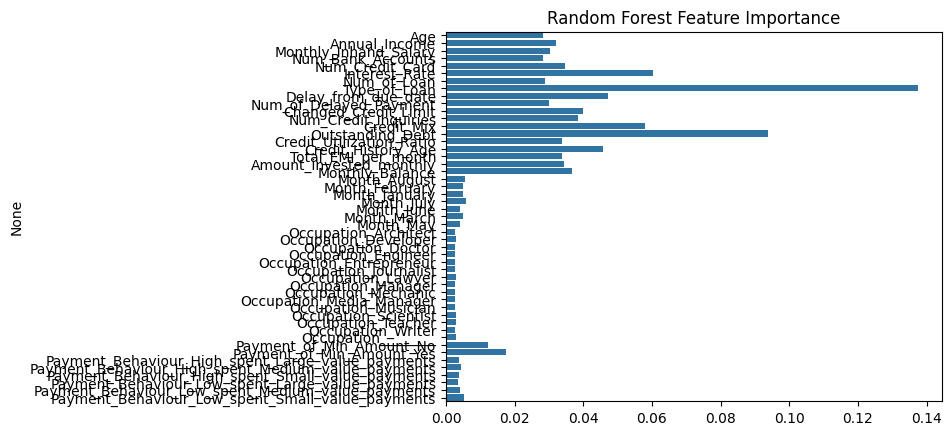

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = rf.feature_importances_
feature_names = X_train.columns
sns.barplot(x=importances, y=feature_names)
plt.title("Random Forest Feature Importance")


In [22]:
from sklearn.inspection import permutation_importance

result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)


Text(0.5, 1.0, 'Feature Likelihoods by Class')

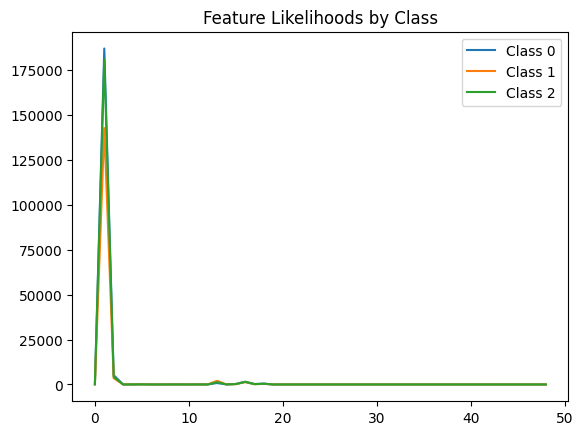

In [23]:
for i, class_label in enumerate(nb.classes_):
    plt.plot(nb.theta_[i], label=f'Class {class_label}')
plt.legend()
plt.title("Feature Likelihoods by Class")


Text(0.5, 1.0, 'Logistic Regression Coefficients')

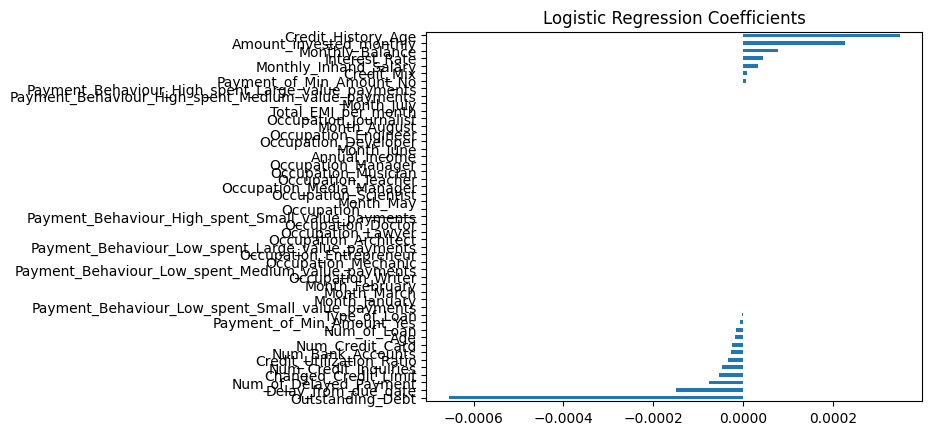

In [24]:
coefs = pd.Series(bayes.coef_[0], index=X_train.columns)
coefs.sort_values().plot(kind='barh')
plt.title("Logistic Regression Coefficients")


In [25]:
import numpy as np
odds_ratios = np.exp(bayes.coef_[0])


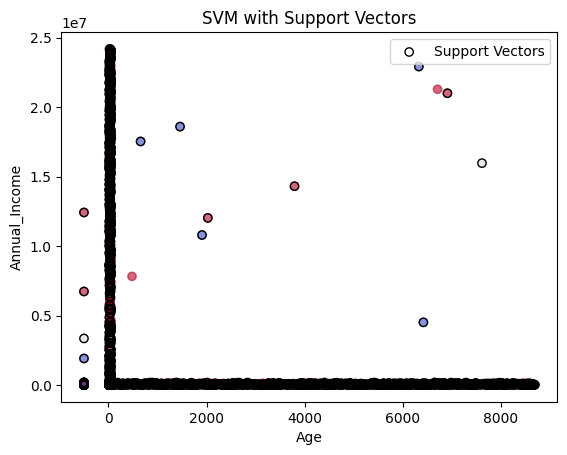

In [27]:
import matplotlib.pyplot as plt

X_array = X_train.values  # convert to NumPy array

plt.scatter(X_array[:, 0], X_array[:, 1], c=y_train, cmap='coolwarm', alpha=0.6)
plt.scatter(svm.support_vectors_[:, 0], svm.support_vectors_[:, 1],
            edgecolors='k', facecolors='none', label='Support Vectors')
plt.xlabel(X_train.columns[0])
plt.ylabel(X_train.columns[1])
plt.title("SVM with Support Vectors")
plt.legend()
plt.show()
